In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy as sc

%matplotlib inline
sp.init_printing()

ModuleNotFoundError: No module named 'sympy.pde'

# Stationary Uniform States
## Zero flux and vegetation

In the case where $b=0$ and $\nabla^2 J=0$ we get $h=\frac{p}{I}$ and $\delta_w \nabla^2 w -\nu w + p =0$
We'll solve for $w$

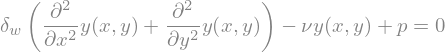

In [23]:
x, y = sp.symbols('x y')
dw = sp.Symbol('\delta_w')
p, v = sp.symbols('p \\nu')

w = sp.Function('y')(x, y)

def laplace(w):
    return sp.diff(w, x, x) + sp.diff(w, y, y)

eq = sp.Eq(dw * laplace(w) - v * w + p, 0)
eq

In [24]:
sp.solvers.pde.pdsolve(eq, w)

NotImplementedError: psolve: Cannot solve \delta_w*(Derivative(y(x, y), (x, 2)) + Derivative(y(x, y), (y, 2))) - \nu*y(x, y) + p

In [9]:
# when b=0 everywhere
y = sp.symbols("y")

w = sp.Function("w")(y)
h = sp.Function("h")(y)

zeta = sp.Function("\\zeta")(y)

w_eq = I*h - v**w + delta_w * sp.diff(w, y, y)
h_eq = p - I*h + 2 * delta_h * sp.diff(h * sp.diff(h+zeta, y), y)

sp.solve((w_eq, h_eq), (w, h))

NotImplementedError: could not solve _Dummy_26*\delta_w + I*(-2*_Dummy_25**2*\delta_h/(2*_Dummy_24*\delta_h - I + 2*\delta_h*Derivative(\zeta(y), (y, 2))) - 2*_Dummy_25*\delta_h*Derivative(\zeta(y), y)/(2*_Dummy_24*\delta_h - I + 2*\delta_h*Derivative(\zeta(y), (y, 2))) - p/(2*_Dummy_24*\delta_h - I + 2*\delta_h*Derivative(\zeta(y), (y, 2)))) - \nu**_X1

In [4]:
nu = 10/3
gamma = 50/3
eta = 3.5
a = 100 / 3
f = 0.1
q = 0.5
rho = 0.5

def eqs(state, p):
    b, w, h = state

    L2 = np.power(1+eta*b, 2)
    Gb = nu*w*L2
    Gw = gamma*b*L2
    I = a * (b + q*f) / (b + q)

    r0 = Gb*b*(1-b) - b 
    r1 = I*h - nu*(1-rho*b)*w - Gw*w
    r2 = p - I*h

    return np.array([r0, r1, r2])

ps = np.linspace(0, 2, 500)
guess = np.array([1, 1, 1])
results = []
for p in ps:
    results.append(sc.optimize.root(eqs, guess, args=p, method="excitingmixing").x)
results = np.array(results)

bs = results[:, 0]
ws = results[:, 1]
hs = results[:, 2]


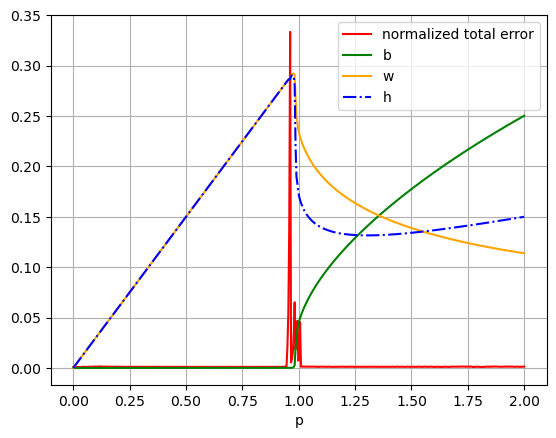

In [5]:
states = np.stack([bs, ws, hs])
errors = eqs(states, ps)
total_error = np.sqrt(np.power(errors[0, :], 2) + np.power(errors[1, :], 2) + np.power(errors[2, :], 2))
total_error /= np.max(total_error) * 3
plt.plot(ps, total_error, label="normalized total error", color="red")

plt.plot(ps, bs, label="b", color="green")
plt.plot(ps, ws, label="w", color="orange")
plt.plot(ps, hs, label="h", linestyle="-.", color="blue")

plt.xlabel("p")
plt.legend()

plt.grid()
plt.show()

# Calculating the Jacobian

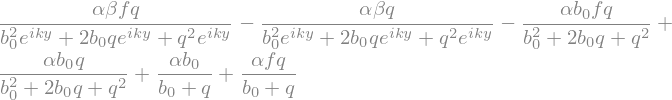

In [6]:
v, eta, gamma, rho, a, q, f = sp.symbols('\\nu \\eta \\gamma \\rho \\alpha q f')
p, delta_b, delta_w, delta_h, curv = sp.symbols('p \\delta_b \\delta_w \\delta_h \\kappa')

y = sp.symbols('y')

b0, w0, h0 = sp.symbols('b_0 w_0 h_0')

k = sp.symbols('k')
E = sp.exp(-sp.I * k * y)

beta, omega, eps = sp.symbols('\\beta \\omega \\epsilon')
 
b = b0
w = w0
h = h0

db = beta * E
dw = omega * E
dh = eps * E

b = b0 + db
w = w0 + dw
h = h0 + dh

Gb = v*w*(1 + eta*b)**2
Gw = gamma*b*(1 + eta*b)**2

I0 = a * (b0 + q*f) / (b0 + q)
I = I0 + a * q * (1-f) / (b0+q)**2 * (b0-db)
I.expand()


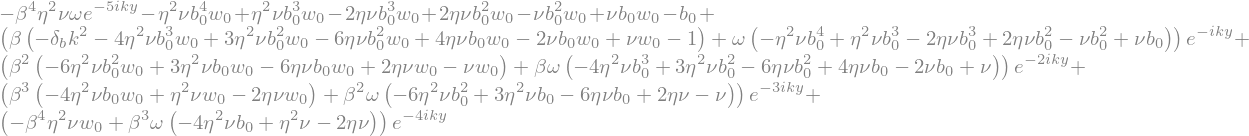

In [7]:
F_b = Gb * b * (1 - b) - b + delta_b * sp.diff(b, y, y)
F_b = F_b.expand().collect(E).collect(beta).collect(omega).collect(eps)
J_b = F_b.coeff(E, 1)
F_b

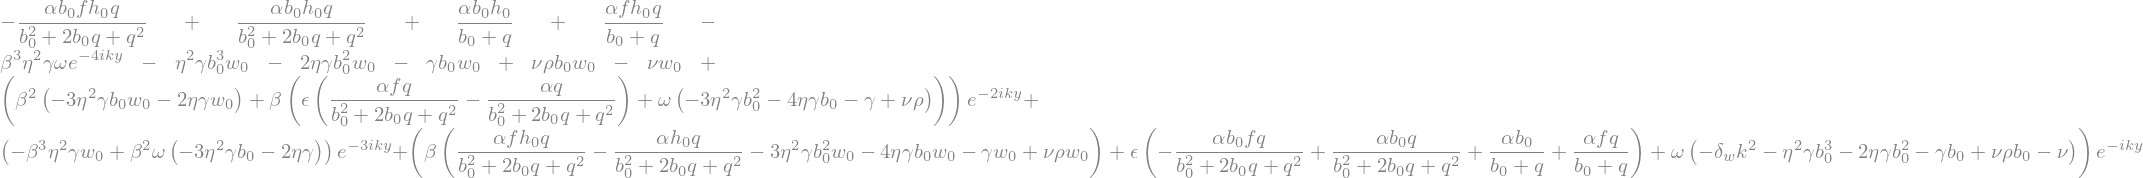

In [8]:
F_w = I*h - v*(1-rho*b)*w - Gw*w + delta_w * sp.diff(w, y, y)
F_w = F_w.expand().collect(E).collect(beta).collect(omega).collect(eps)
J_w = F_w.coeff(E, 1)

F_w

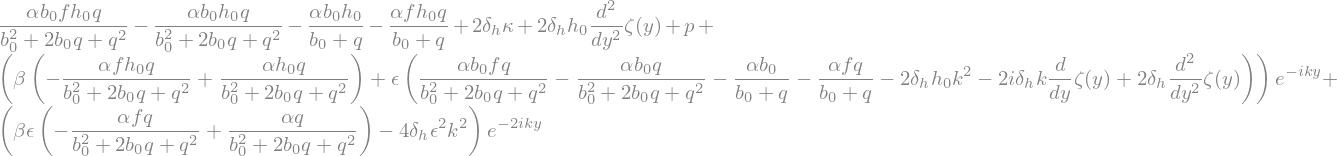

In [9]:
zeta = sp.Function('\\zeta')(y)
F_h = p - I*h + 2*delta_h*curv + 2 * delta_h * sp.diff(h * sp.diff(h + zeta, y), y)
F_h = F_h.expand().collect(E).collect(beta).collect(omega).collect(eps)
J_h = F_h.coeff(E, 1)

F_h

\left[\begin{matrix}- \delta_{b} k^{2} - 4 \eta^{2} \nu b_{0}^{3} w_{0} + 3 \eta^{2} \nu b_{0}^{2} w_{0} - 6 \eta \nu b_{0}^{2} w_{0} + 4 \eta \nu b_{0} w_{0} - 2 \nu b_{0} w_{0} + \nu w_{0} - 1 & - \eta^{2} \nu b_{0}^{4} + \eta^{2} \nu b_{0}^{3} - 2 \eta \nu b_{0}^{3} + 2 \eta \nu b_{0}^{2} - \nu b_{0}^{2} + \nu b_{0} & 0\\\frac{\alpha f h_{0} q}{b_{0}^{2} + 2 b_{0} q + q^{2}} - \frac{\alpha h_{0} q}{b_{0}^{2} + 2 b_{0} q + q^{2}} - 3 \eta^{2} \gamma b_{0}^{2} w_{0} - 4 \eta \gamma b_{0} w_{0} - \gamma w_{0} + \nu \rho w_{0} & - \delta_{w} k^{2} - \eta^{2} \gamma b_{0}^{3} - 2 \eta \gamma b_{0}^{2} - \gamma b_{0} + \nu \rho b_{0} - \nu & - \frac{\alpha b_{0} f q}{b_{0}^{2} + 2 b_{0} q + q^{2}} + \frac{\alpha b_{0} q}{b_{0}^{2} + 2 b_{0} q + q^{2}} + \frac{\alpha b_{0}}{b_{0} + q} + \frac{\alpha f q}{b_{0} + q}\\- \frac{\alpha f h_{0} q}{b_{0}^{2} + 2 b_{0} q + q^{2}} + \frac{\alpha h_{0} q}{b_{0}^{2} + 2 b_{0} q + q^{2}} & 0 & \frac{\alpha b_{0} f q}{b_{0}^{2} + 2 b_{0} q + q^{2}} - \

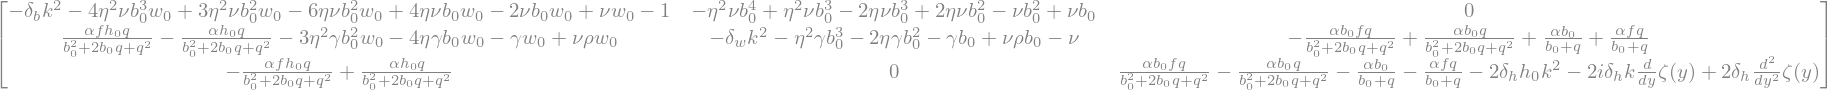

In [10]:
J = sp.Matrix([[J_b.coeff(beta, 1), J_b.coeff(omega, 1), J_b.coeff(eps, 1)], \
               [J_w.coeff(beta, 1), J_w.coeff(omega, 1), J_w.coeff(eps, 1)], \
               [J_h.coeff(beta, 1), J_h.coeff(omega, 1), J_h.coeff(eps, 1)]])
sp.print_latex(J)
J

\left[\begin{matrix}- \delta_{b} k^{2} + \nu \left(\frac{2 \delta_{h} \frac{d^{2}}{d y^{2}} \zeta{\left(y \right)}}{\nu} + \frac{p}{\nu}\right) - 1 & 0 & 0\\\frac{\alpha f \left(\frac{2 \delta_{h} \frac{d^{2}}{d y^{2}} \zeta{\left(y \right)}}{\alpha f} + \frac{p}{\alpha f}\right)}{q} - \frac{\alpha \left(\frac{2 \delta_{h} \frac{d^{2}}{d y^{2}} \zeta{\left(y \right)}}{\alpha f} + \frac{p}{\alpha f}\right)}{q} - \gamma \left(\frac{2 \delta_{h} \frac{d^{2}}{d y^{2}} \zeta{\left(y \right)}}{\nu} + \frac{p}{\nu}\right) + \nu \rho \left(\frac{2 \delta_{h} \frac{d^{2}}{d y^{2}} \zeta{\left(y \right)}}{\nu} + \frac{p}{\nu}\right) & - \delta_{w} k^{2} - \nu & \alpha f\\- \frac{\alpha f \left(\frac{2 \delta_{h} \frac{d^{2}}{d y^{2}} \zeta{\left(y \right)}}{\alpha f} + \frac{p}{\alpha f}\right)}{q} + \frac{\alpha \left(\frac{2 \delta_{h} \frac{d^{2}}{d y^{2}} \zeta{\left(y \right)}}{\alpha f} + \frac{p}{\alpha f}\right)}{q} & 0 & - \alpha f - 2 \delta_{h} k^{2} \cdot \left(\frac{2 \delta_{h} \fr

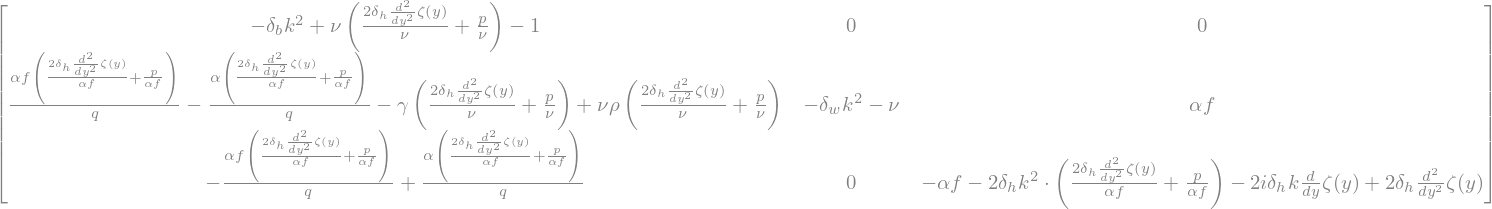

In [15]:
m = sp.symbols('m')
J0 = J.subs({b0: 0, w0: p/v + 2 * delta_h / v * sp.diff(zeta, y, y), h0:p/(a*f) + 2 * delta_h / (a * f) * sp.diff(zeta, y, y)})
sp.print_latex(J0)
J0

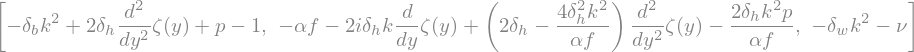

In [20]:
A = list(J0.eigenvals().keys())
B = [x.expand().collect(sp.diff(zeta, y, y)) for x in A]
B
